In [ ]:
from google.colab import drive

drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
import torchsummary
import numpy as np
from PIL import Image
import json
import time
import random
import h5py


In [ ]:
def seed_everything(seed=42):
    random.seed(seed)  # Python random 모듈
    np.random.seed(seed)  # Numpy 랜덤 시드
    torch.manual_seed(seed)  # PyTorch 랜덤 시드
    torch.cuda.manual_seed(seed)  # GPU를 위한 PyTorch 랜덤 시드
    torch.cuda.manual_seed_all(seed)  # 멀티 GPU를 위한 PyTorch 랜덤 시드

seed_everything()

# 데이터셋 정의

In [ ]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, hdf5, transform=None):
        self.transform = transform
        self.file_object = h5py.File(hdf5, 'r')
        self.keys = list(self.file_object['image'].keys())

    def __len__(self):
        return len(self.keys)

    def __getitem__(self, index):
        key = self.keys[index]
        image = self.file_object['image'][key][:]
        age = self.file_object['age'][key][()]
        box = self.file_object['box'][key][()]

        # 먼저 어레이를 PIL 이미지로 변환
        image = Image.fromarray(image)
        image = image.crop((box[0], box[1], box[0] + box[2], box[1] + box[3]))

        if self.transform:
            image = self.transform(image)

        label = {'age_past': age}

        return image, label

    def close(self):
        self.file_object.close()


In [ ]:
# 40대 이상 데이터 오버샘플링 - 비율 역수 가중치 부여
class OverSampleDataset(torch.utils.data.Dataset):
    def __init__(self, hdf5, transform=None):
        self.transform = transform
        self.file_object = h5py.File(hdf5, 'r')
        self.keys = list(self.file_object['image'].keys())

        # 연령대별 키 분류
        self.age_groups = {
            'below_60': [],
            # '40s': [],
            # '50s': [],
            '60s_plus': []
        }
        for key in self.keys:
            age = self.file_object['age'][key][()]
            if age < 60:
                self.age_groups['below_60'].append(key)
            # elif age < 50:
            #     self.age_groups['40s'].append(key)
            # elif age < 60:
                # self.age_groups['50s'].append(key)
            else:
                self.age_groups['60s_plus'].append(key)

        # 오버 샘플링 비율 계산 및 적용
        over_sampled_keys = self.age_groups['below_60']
        for group, keys in self.age_groups.items():
            if group == 'below_60':
                continue
            # oversample_rate = max(1, len(over_sampled_keys) / len(keys))  # 비율의 역수 계산, 최소 1배는 유지
            oversample_rate = 4
            oversampled_keys = np.random.choice(keys, int(len(keys) * oversample_rate), replace=True).tolist()
            over_sampled_keys.extend(oversampled_keys)  # 오버샘플링된 키 추가

        self.over_sampled_keys = over_sampled_keys

    def __len__(self):
        return len(self.over_sampled_keys)

    def __getitem__(self, index):
        key = self.over_sampled_keys[index]
        image = self.file_object['image'][key][:]
        age = self.file_object['age'][key][()]
        box = self.file_object['box'][key][()]

        image = Image.fromarray(image)
        image = image.crop((box[0], box[1], box[0] + box[2], box[1] + box[3]))

        if self.transform:
            image = self.transform(image)

        label = {'age_past': age}

        return image, label

    def close(self):
        self.file_object.close()


In [ ]:
# 랜덤하게 적용
random_transforms = transforms.RandomApply([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2)
], p=0.6)

# 항상 적용
always_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.6284, 0.4901, 0.4325], std=[0.1869, 0.1712, 0.1561]),
])

transform_train = transforms.Compose([
    random_transforms,
    always_transforms
])

transform_val = transforms.Compose([
    always_transforms
])

In [ ]:
train_dataset = OverSampleDataset('/content/drive/MyDrive/DL_DATA/DL_Face_REC/data_age_train.hdf5', transform=transform_train)
val_dataset = CustomDataset('/content/drive/MyDrive/DL_DATA/DL_Face_REC/data_age_val.hdf5', transform=transform_val)

In [ ]:
batch_size = 256

train_loader = torch.utils.data.DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=2,
    prefetch_factor=8
)

val_loader = torch.utils.data.DataLoader(
    dataset=val_dataset,
    batch_size=batch_size,
    num_workers=2,
    prefetch_factor=8
)

In [ ]:
len(train_loader), len(val_loader)

(160, 20)

In [ ]:
# # DataLoader에서 단일 배치 테스트
# def test_single_batch(data_loader):
#     for data, labels in data_loader:
#         print("Data shape:", data.shape)
#         print("Labels shape:", labels['age_past'].shape)
#         break

# # DataLoader 전체 테스트
# def test_full_loader(data_loader):
#     for i, (data, labels) in enumerate(data_loader):
#         if i % 10 == 0:
#             print(f"Batch {i}, Data shape: {data.shape}, Labels shape: {labels['age_past'].shape}")

# # val_loader 테스트 실행
# print("Testing single batch from val_loader:")
# test_single_batch(val_loader)

# print("\nTesting full val_loader:")
# test_full_loader(val_loader)

Testing single batch from val_loader:
Data shape: torch.Size([256, 3, 224, 224])
Labels shape: torch.Size([256])

Testing full val_loader:
Batch 0, Data shape: torch.Size([256, 3, 224, 224]), Labels shape: torch.Size([256])
Batch 10, Data shape: torch.Size([256, 3, 224, 224]), Labels shape: torch.Size([256])


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


# 모델 - ResNet

In [ ]:
def conv3x3(in_planes, out_planes, stride=1):
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride, padding=1, bias=False)

def conv1x1(in_planes, out_planes, stride=1):
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)

In [ ]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1, downsample=None):
        super().__init__()
        self.conv1 = conv3x3(in_planes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x) # 3x3, stride=stride
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out) # 3x3, stride=1 고정
        out = self.bn2(out)

        # stride!=1 일 때, identity와 out의 shape을 일치시키기 위한 downsample
        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)
        return out

In [ ]:
class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1, downsample=None):
        super().__init__()
        self.conv1 = conv1x1(in_planes, planes)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = conv3x3(planes, planes, stride)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = conv1x1(planes, planes * self.expansion)
        self.bn3 = nn.BatchNorm2d(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.stride = stride
        self.downsample = downsample

    def forward(self, x):
        identity = x

        out = self.conv1(x) # 1x1, stride=1
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out) # 3x3, stride=stride
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out) # 1x1, planes * self.expansion
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)
        return out

In [ ]:
class Age_Net(nn.Module):
    # resnet50 : Bottleneck, [3, 4, 6, 3]
    # resnet18 : BasicBlock, [2, 2, 2, 2]
    def __init__(self, block, layers):
        super().__init__()
        self.inplanes = 64

        # input.shape : (3, 224, 224)
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        # output.shape : (64, 112, 112)

        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)

        # output.shape : (64, 112, 112)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        # output.shape : (64, 56, 56)

        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, 1)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)


    def _make_layer(self, block, planes, blocks, stride=1):
        # 예 : self.layer1 => _make_layer(Bottleneck, 64, 3)
        # 채널수를 맞추기 위한 downsample
        downsample = None
        if stride!=1 or self.inplanes!=planes*block.expansion: # self.inplanes=64 != 64 * 4
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride), #conv1x1(64, 64*4, stride=1)
                nn.BatchNorm2d(planes * block.expansion)
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample)) # Bottleneck(64, 64, 1, downsample)
        self.inplanes = planes * block.expansion # self.inplanes = 64 * 4

        for _ in range(1, blocks): # 반복횟수 2번
            layers.append(block(self.inplanes, planes))

        # self.layer1 = [
        #     Bottleneck(64, 64, 1, downsample),
        #     Bottleneck(256, 64),
        #     Bottleneck(256, 64),
        # ]
        # self.layer2 = [
        #     Bottleneck(256, 128, 2, downsample),
        #     Bottleneck(512, 128),
        #     Bottleneck(512, 128),
        #     Bottleneck(512, 128),
        # ]

        return nn.Sequential(*layers)


    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x) # fc 대체
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        x = self.relu(x)
        out = x.squeeze()
        return out


In [ ]:
# def resnet50():
#     model = Age_Net(Bottleneck, [3, 4, 6, 3])
#     return model

In [ ]:
def resnet18():
    model = Age_Net(BasicBlock, [2, 2, 2, 2])
    return model

In [ ]:
age_model = resnet18().to(device)
torchsummary.summary(age_model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

# 학습과정

In [ ]:
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.optim as optim

opt_age = optim.Adam(age_model.parameters(), lr=0.0003)
age_lr_scheduler = ReduceLROnPlateau(opt_age, mode='min', verbose=True)

In [ ]:
class EarlyStopping:
    def __init__(self, patience=3, verbose=False, delta=0):
        self.patience = patience
        self.verbose = verbose
        self.delta = delta
        self.best_loss = np.inf
        self.early_stop = False
        self.counter = 0

    def __call__(self, val_loss):
        if self.best_loss - val_loss > self.delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
                if self.verbose:
                    print("Early stopping")

In [ ]:
early_stopping = EarlyStopping(patience=3, verbose=True)

In [ ]:
def train_loop_age(dataloader, model, loss_fn, optimizer, epoch):
    model.train()
    size = len(dataloader.dataset)
    total_loss = 0.0
    start_time = time.time()  # 에포크 시작 시간

    for batch, (x, y) in enumerate(dataloader):
        batch_start_time = time.time()  # 배치 처리 시작 시간
        x, y = x.to(device), y['age_past'].float().to(device)
        pred = model(x)
        loss = loss_fn(pred.squeeze(), y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

        batch_process_time = time.time() - batch_start_time

        if batch % 10 == 0:
            processed = (batch + 1) * len(x)
            print(f'Epoch {epoch+1} : [{processed} / {size}] loss : {loss.item()}, Batch time: {batch_process_time:.4f} sec')

    average_loss = total_loss / len(dataloader)
    epoch_time = time.time() - start_time

    print(f"Epoch {epoch+1} finished, Total Epoch time: {epoch_time:.4f} sec")
    return average_loss


In [ ]:
def validation_loop_age(dataloader, model, loss_fn, device):
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for x, y in dataloader:
            x, y = x.to(device), y['age_past'].float().to(device)
            pred = model(x)
            loss = loss_fn(pred, y)
            val_loss += loss.item()
    val_loss /= len(dataloader)
    return val_loss

In [ ]:
def save_model(epoch, model, optimizer, path, train_loss, val_loss, scheduler):
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'train_loss': train_loss,
        'val_loss': val_loss,
        'scheduler': scheduler.state_dict() # 스케쥴러도 함께 저장
    }, path)

In [ ]:
# start = time.time()
# for epoch in range(30):
#     age_loss = train_loop_age(train_loader, age_model, nn.MSELoss(), opt_age, epoch)
#     val_loss = validation_loop_age(val_loader, age_model, nn.MSELoss(), device)
#     age_lr_scheduler.step(val_loss)

#     early_stopping(val_loss)
#     if early_stopping.early_stop:
#         print("Early stopping triggered")
#         save_model(epoch, age_model, opt_age, '/content/drive/MyDrive/DL_DATA/DL_Face_REC/Model/resnet50/age_model_checkpoint.pth', age_loss, val_loss)
#         break

#     save_model(epoch, age_model, opt_age,
#                f'/content/drive/MyDrive/DL_DATA/DL_Face_REC/Model/resnet50/age_model_checkpoint_epoch_{epoch+1}_loss_{round(age_loss, 2)}.pth',
#                age_loss, val_loss)
#     print(f'Epoch : {epoch+1}, Loss : {age_loss}, Val_loss : {val_loss}')

# total_time = time.time() - start

# # 전체 학습 시간 출력
# hours, rem = divmod(total_time, 3600)
# minutes, seconds = divmod(rem, 60)
# print("Total training time: {:0>2}:{:0>2}:{:05.2f}".format(int(hours),int(minutes),seconds))

Epoch 1 : [256 / 40150] loss : 620.211181640625, Batch time: 0.7497 sec
Epoch 1 : [2816 / 40150] loss : 442.4517517089844, Batch time: 0.7559 sec
Epoch 1 : [5376 / 40150] loss : 425.8517761230469, Batch time: 0.7681 sec
Epoch 1 : [7936 / 40150] loss : 363.48175048828125, Batch time: 0.8170 sec
Epoch 1 : [10496 / 40150] loss : 270.2467956542969, Batch time: 0.7675 sec
Epoch 1 : [13056 / 40150] loss : 264.0320129394531, Batch time: 0.7747 sec
Epoch 1 : [15616 / 40150] loss : 216.3939208984375, Batch time: 0.7934 sec
Epoch 1 : [18176 / 40150] loss : 218.99313354492188, Batch time: 0.7654 sec
Epoch 1 : [20736 / 40150] loss : 155.1727294921875, Batch time: 0.7314 sec
Epoch 1 : [23296 / 40150] loss : 199.57672119140625, Batch time: 0.7393 sec
Epoch 1 : [25856 / 40150] loss : 124.1175765991211, Batch time: 0.7612 sec
Epoch 1 : [28416 / 40150] loss : 124.23149108886719, Batch time: 0.7543 sec
Epoch 1 : [30976 / 40150] loss : 97.66551208496094, Batch time: 0.7602 sec
Epoch 1 : [33536 / 40150] l

KeyboardInterrupt: 

# 이어서 학습

In [ ]:
# age 모델 이어서 학습
def load_model(model, optimizer, path, scheduler):
    checkpoint = torch.load(path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    scheduler.load_state_dict(checkpoint['scheduler'])
    return model, optimizer, epoch, scheduler

In [ ]:
# # 모델과 옵티마이저 초기화
# age_model = resnet18().to(device)
# opt_age = optim.Adam(age_model.parameters(), lr=0.0003)

# # 체크포인트 불러오기
# age_model, opt_age, start_epoch = load_model(age_model, opt_age, '/content/drive/MyDrive/DL_DATA/DL_Face_REC/Model/resnet50/age_model_checkpoint_epoch_1_loss_230.39.pth')

# # 학습 재개
# start = time.time()
# for epoch in range(start_epoch + 1, 30):
#     age_loss = train_loop_age(train_loader, age_model, nn.MSELoss(), opt_age, epoch)
#     val_loss = validation_loop_age(val_loader, age_model, nn.MSELoss(), device)
#     age_lr_scheduler.step(val_loss)

#     early_stopping(val_loss)
#     if early_stopping.early_stop:
#         print("Early stopping triggered")
#         save_model(epoch, age_model, opt_age, '/content/drive/MyDrive/DL_DATA/DL_Face_REC/Model/resnet50/age_model_checkpoint.pth')
#         break

#     save_model(epoch, age_model, opt_age,
#                f'/content/drive/MyDrive/DL_DATA/DL_Face_REC/Model/resnet50/age_model_checkpoint_epoch_{epoch+1}_loss_{round(age_loss, 2)}.pth',
#                age_loss, val_loss)

#     print(f'Epoch : {epoch + 1}, Loss : {age_loss}, Val_loss : {val_loss}')

# total_time = time.time() - start

# hours, rem = divmod(total_time, 3600)
# minutes, seconds = divmod(rem, 60)
# print("Total training time: {:0>2}:{:0>2}:{:05.2f}".format(int(hours),int(minutes),seconds))

Epoch 2 : [256 / 40150] loss : 94.12299346923828, Batch time: 0.7252 sec
Epoch 2 : [2816 / 40150] loss : 102.92778015136719, Batch time: 0.8078 sec
Epoch 2 : [5376 / 40150] loss : 109.08277893066406, Batch time: 0.8174 sec
Epoch 2 : [7936 / 40150] loss : 92.99151611328125, Batch time: 0.7482 sec
Epoch 2 : [10496 / 40150] loss : 88.91162109375, Batch time: 0.8232 sec
Epoch 2 : [13056 / 40150] loss : 98.66921997070312, Batch time: 0.7470 sec
Epoch 2 : [15616 / 40150] loss : 88.40391540527344, Batch time: 0.7327 sec
Epoch 2 : [18176 / 40150] loss : 99.3305435180664, Batch time: 0.7604 sec
Epoch 2 : [20736 / 40150] loss : 77.51795959472656, Batch time: 0.8029 sec
Epoch 2 : [23296 / 40150] loss : 80.04756164550781, Batch time: 0.8265 sec
Epoch 2 : [25856 / 40150] loss : 76.47883605957031, Batch time: 0.7822 sec
Epoch 2 : [28416 / 40150] loss : 87.84364318847656, Batch time: 0.7396 sec
Epoch 2 : [30976 / 40150] loss : 76.25796508789062, Batch time: 0.7963 sec
Epoch 2 : [33536 / 40150] loss :

KeyboardInterrupt: 

In [ ]:
# # 모델과 옵티마이저, 스케줄러
# age_model = resnet18().to(device)
# opt_age = optim.Adam(age_model.parameters(), lr=0.0003)
# age_lr_scheduler = ReduceLROnPlateau(opt_age, mode='min', verbose=True)

# # 체크포인트 불러오기
# age_model, opt_age, start_epoch = load_model(age_model, opt_age,
#                                              '/content/drive/MyDrive/DL_DATA/DL_Face_REC/Model/resnet50/age_model_checkpoint_epoch_4_loss_50.99.pth')

# # 학습 재개
# start = time.time()
# for epoch in range(start_epoch + 1, 30):
#     age_loss = train_loop_age(train_loader, age_model, nn.MSELoss(), opt_age, epoch)
#     val_loss = validation_loop_age(val_loader, age_model, nn.MSELoss(), device)
#     age_lr_scheduler.step(val_loss)

#     early_stopping(val_loss)
#     if early_stopping.early_stop:
#         print("Early stopping triggered")
#         save_model(epoch, age_model, opt_age, '/content/drive/MyDrive/DL_DATA/DL_Face_REC/Model/resnet50/age_model_checkpoint.pth', age_lr_scheduler)
#         break

#     save_model(epoch, age_model, opt_age,
#                f'/content/drive/MyDrive/DL_DATA/DL_Face_REC/Model/resnet50/age_model_checkpoint_epoch_{epoch+1}_loss_{round(age_loss, 2)}.pth',
#                age_loss, val_loss, age_lr_scheduler)

#     print(f'Epoch : {epoch + 1}, Loss : {age_loss}, Val_loss : {val_loss}')

# total_time = time.time() - start

# hours, rem = divmod(total_time, 3600)
# minutes, seconds = divmod(rem, 60)
# print("Total training time: {:0>2}:{:0>2}:{:05.2f}".format(int(hours),int(minutes),seconds))

Epoch 5 : [256 / 40150] loss : 50.69894027709961, Batch time: 0.9533 sec
Epoch 5 : [2816 / 40150] loss : 45.6611328125, Batch time: 0.7698 sec
Epoch 5 : [5376 / 40150] loss : 42.61809539794922, Batch time: 0.8331 sec
Epoch 5 : [7936 / 40150] loss : 52.96070861816406, Batch time: 0.7882 sec
Epoch 5 : [10496 / 40150] loss : 35.39765167236328, Batch time: 0.7765 sec
Epoch 5 : [13056 / 40150] loss : 42.10182571411133, Batch time: 0.7290 sec
Epoch 5 : [15616 / 40150] loss : 35.59788513183594, Batch time: 0.8343 sec
Epoch 5 : [18176 / 40150] loss : 35.001773834228516, Batch time: 0.7288 sec
Epoch 5 : [20736 / 40150] loss : 40.91498947143555, Batch time: 0.8398 sec
Epoch 5 : [23296 / 40150] loss : 42.64820861816406, Batch time: 0.7250 sec
Epoch 5 : [25856 / 40150] loss : 35.12820053100586, Batch time: 0.7698 sec
Epoch 5 : [28416 / 40150] loss : 34.50324249267578, Batch time: 0.8428 sec
Epoch 5 : [30976 / 40150] loss : 49.314910888671875, Batch time: 0.7449 sec
Epoch 5 : [33536 / 40150] loss :

KeyboardInterrupt: 

In [ ]:
# # 모델과 옵티마이저, 스케줄러
# age_model = resnet18().to(device)
# opt_age = optim.Adam(age_model.parameters(), lr=0.0003)
# age_lr_scheduler = ReduceLROnPlateau(opt_age, mode='min', verbose=True)

# # 체크포인트 불러오기
# age_model, opt_age, start_epoch = load_model(age_model, opt_age,
#                                              '/content/drive/MyDrive/DL_DATA/DL_Face_REC/Model/resnet50/age_model_checkpoint_epoch_10_loss_24.48.pth')

# # 학습 재개
# start = time.time()
# for epoch in range(start_epoch + 1, 30):
#     age_loss = train_loop_age(train_loader, age_model, nn.MSELoss(), opt_age, epoch)
#     val_loss = validation_loop_age(val_loader, age_model, nn.MSELoss(), device)
#     age_lr_scheduler.step(val_loss)

#     early_stopping(val_loss)
#     if early_stopping.early_stop:
#         print("Early stopping triggered")
#         save_model(epoch, age_model, opt_age, '/content/drive/MyDrive/DL_DATA/DL_Face_REC/Model/resnet50/age_model_checkpoint.pth', age_lr_scheduler)
#         break

#     save_model(epoch, age_model, opt_age,
#                f'/content/drive/MyDrive/DL_DATA/DL_Face_REC/Model/resnet50/age_model_checkpoint_epoch_{epoch+1}_loss_{round(age_loss, 2)}.pth',
#                age_loss, val_loss, age_lr_scheduler)

#     print(f'Epoch : {epoch + 1}, Loss : {age_loss}, Val_loss : {val_loss}')

# total_time = time.time() - start

# hours, rem = divmod(total_time, 3600)
# minutes, seconds = divmod(rem, 60)
# print("Total training time: {:0>2}:{:0>2}:{:05.2f}".format(int(hours),int(minutes),seconds))

Epoch 11 : [256 / 40150] loss : 18.147829055786133, Batch time: 1.4154 sec
Epoch 11 : [2816 / 40150] loss : 20.589080810546875, Batch time: 0.7477 sec
Epoch 11 : [5376 / 40150] loss : 29.835887908935547, Batch time: 0.7743 sec
Epoch 11 : [7936 / 40150] loss : 23.153087615966797, Batch time: 0.8172 sec
Epoch 11 : [10496 / 40150] loss : 22.63701820373535, Batch time: 0.7608 sec
Epoch 11 : [13056 / 40150] loss : 22.95894432067871, Batch time: 0.7706 sec
Epoch 11 : [15616 / 40150] loss : 20.60475730895996, Batch time: 0.7739 sec
Epoch 11 : [18176 / 40150] loss : 27.96178436279297, Batch time: 0.7661 sec
Epoch 11 : [20736 / 40150] loss : 24.938385009765625, Batch time: 0.7621 sec
Epoch 11 : [23296 / 40150] loss : 26.141006469726562, Batch time: 0.7577 sec
Epoch 11 : [25856 / 40150] loss : 23.505859375, Batch time: 0.8828 sec
Epoch 11 : [28416 / 40150] loss : 24.296424865722656, Batch time: 0.7500 sec
Epoch 11 : [30976 / 40150] loss : 27.778701782226562, Batch time: 0.7848 sec
Epoch 11 : [33

KeyboardInterrupt: 

In [ ]:
# # 모델과 옵티마이저, 스케줄러
# age_model = resnet18().to(device)
# opt_age = optim.Adam(age_model.parameters(), lr=0.0003)
# age_lr_scheduler = ReduceLROnPlateau(opt_age, mode='min', verbose=True)

# # 체크포인트 불러오기
# age_model, opt_age, start_epoch, age_lr_scheduler = load_model(age_model, opt_age,
#                                              '/content/drive/MyDrive/DL_DATA/DL_Face_REC/Model/resnet50/age_model_checkpoint_epoch_16_loss_17.62.pth',
#                                                                age_lr_scheduler)

# # 학습 재개
# start = time.time()
# for epoch in range(start_epoch + 1, 30):
#     age_loss = train_loop_age(train_loader, age_model, nn.MSELoss(), opt_age, epoch)
#     val_loss = validation_loop_age(val_loader, age_model, nn.MSELoss(), device)
#     age_lr_scheduler.step(val_loss)

#     early_stopping(val_loss)
#     if early_stopping.early_stop:
#         print("Early stopping triggered")
#         save_model(epoch, age_model, opt_age, '/content/drive/MyDrive/DL_DATA/DL_Face_REC/Model/resnet50/age_model_checkpoint.pth', age_lr_scheduler)
#         break

#     save_model(epoch, age_model, opt_age,
#                f'/content/drive/MyDrive/DL_DATA/DL_Face_REC/Model/resnet50/age_model_checkpoint_epoch_{epoch+1}_loss_{round(age_loss, 2)}.pth',
#                age_loss, val_loss, age_lr_scheduler)

#     print(f'Epoch : {epoch + 1}, Loss : {age_loss}, Val_loss : {val_loss}')

# total_time = time.time() - start

# hours, rem = divmod(total_time, 3600)
# minutes, seconds = divmod(rem, 60)
# print("Total training time: {:0>2}:{:0>2}:{:05.2f}".format(int(hours),int(minutes),seconds))

Epoch 17 : [256 / 40150] loss : 20.68964385986328, Batch time: 1.5075 sec
Epoch 17 : [2816 / 40150] loss : 15.438434600830078, Batch time: 0.8314 sec
Epoch 17 : [5376 / 40150] loss : 17.762985229492188, Batch time: 0.7518 sec
Epoch 17 : [7936 / 40150] loss : 14.694768905639648, Batch time: 0.8022 sec
Epoch 17 : [10496 / 40150] loss : 14.576712608337402, Batch time: 0.7690 sec
Epoch 17 : [13056 / 40150] loss : 22.412134170532227, Batch time: 0.7482 sec
Epoch 17 : [15616 / 40150] loss : 17.247373580932617, Batch time: 0.7440 sec
Epoch 17 : [18176 / 40150] loss : 20.040821075439453, Batch time: 0.7415 sec
Epoch 17 : [20736 / 40150] loss : 15.802120208740234, Batch time: 0.7585 sec
Epoch 17 : [23296 / 40150] loss : 15.704845428466797, Batch time: 0.8484 sec
Epoch 17 : [25856 / 40150] loss : 12.29332447052002, Batch time: 0.7421 sec
Epoch 17 : [28416 / 40150] loss : 19.955402374267578, Batch time: 0.7408 sec
Epoch 17 : [30976 / 40150] loss : 17.77524185180664, Batch time: 0.7206 sec
Epoch 1

KeyboardInterrupt: 

In [ ]:
# # 모델과 옵티마이저, 스케줄러
# age_model = resnet18().to(device)
# opt_age = optim.Adam(age_model.parameters(), lr=0.0003)
# age_lr_scheduler = ReduceLROnPlateau(opt_age, mode='min', verbose=True)

# # 체크포인트 불러오기
# age_model, opt_age, start_epoch, age_lr_scheduler = load_model(age_model, opt_age,
#                                              '/content/drive/MyDrive/DL_DATA/DL_Face_REC/Model/resnet50/age_model_checkpoint_epoch_21_loss_14.01.pth',
#                                                                age_lr_scheduler)

# # 학습 재개
# start = time.time()
# for epoch in range(start_epoch + 1, 30):
#     age_loss = train_loop_age(train_loader, age_model, nn.MSELoss(), opt_age, epoch)
#     val_loss = validation_loop_age(val_loader, age_model, nn.MSELoss(), device)
#     age_lr_scheduler.step(val_loss)

#     early_stopping(val_loss)
#     if early_stopping.early_stop:
#         print("Early stopping triggered")
#         save_model(epoch, age_model, opt_age, '/content/drive/MyDrive/DL_DATA/DL_Face_REC/Model/resnet50/age_model_checkpoint.pth', age_lr_scheduler)
#         break

#     save_model(epoch, age_model, opt_age,
#                f'/content/drive/MyDrive/DL_DATA/DL_Face_REC/Model/resnet50/age_model_checkpoint_epoch_{epoch+1}_loss_{round(age_loss, 2)}.pth',
#                age_loss, val_loss, age_lr_scheduler)

#     print(f'Epoch : {epoch + 1}, Loss : {age_loss}, Val_loss : {val_loss}')

# total_time = time.time() - start

# hours, rem = divmod(total_time, 3600)
# minutes, seconds = divmod(rem, 60)
# print("Total training time: {:0>2}:{:0>2}:{:05.2f}".format(int(hours),int(minutes),seconds))

Epoch 22 : [256 / 40150] loss : 9.00929069519043, Batch time: 1.7860 sec
Epoch 22 : [2816 / 40150] loss : 10.905038833618164, Batch time: 0.7571 sec
Epoch 22 : [5376 / 40150] loss : 12.932657241821289, Batch time: 0.7482 sec
Epoch 22 : [7936 / 40150] loss : 14.396778106689453, Batch time: 0.7445 sec
Epoch 22 : [10496 / 40150] loss : 14.311525344848633, Batch time: 0.7221 sec
Epoch 22 : [13056 / 40150] loss : 12.153982162475586, Batch time: 0.8015 sec
Epoch 22 : [15616 / 40150] loss : 9.018627166748047, Batch time: 0.7349 sec
Epoch 22 : [18176 / 40150] loss : 12.963970184326172, Batch time: 0.7226 sec
Epoch 22 : [20736 / 40150] loss : 13.445266723632812, Batch time: 0.7228 sec
Epoch 22 : [23296 / 40150] loss : 11.120243072509766, Batch time: 0.8014 sec
Epoch 22 : [25856 / 40150] loss : 10.126775741577148, Batch time: 0.7652 sec
Epoch 22 : [28416 / 40150] loss : 10.079791069030762, Batch time: 0.7327 sec
Epoch 22 : [30976 / 40150] loss : 9.728004455566406, Batch time: 0.7539 sec
Epoch 22

KeyboardInterrupt: 

In [ ]:
# 모델과 옵티마이저, 스케줄러
age_model = resnet18().to(device)
opt_age = optim.Adam(age_model.parameters(), lr=0.0003)
age_lr_scheduler = ReduceLROnPlateau(opt_age, mode='min', verbose=True)

# 체크포인트 불러오기
age_model, opt_age, start_epoch, age_lr_scheduler = load_model(age_model, opt_age,
                                             '/content/drive/MyDrive/DL_DATA/DL_Face_REC/Model/resnet50/age_model_checkpoint_epoch_21_loss_14.01.pth',
                                                               age_lr_scheduler)

# 학습 재개
start = time.time()
for epoch in range(start_epoch + 1, 30):
    age_loss = train_loop_age(train_loader, age_model, nn.MSELoss(), opt_age, epoch)
    val_loss = validation_loop_age(val_loader, age_model, nn.MSELoss(), device)
    age_lr_scheduler.step(val_loss)

    early_stopping(val_loss)
    if early_stopping.early_stop:
        print("Early stopping triggered")
        save_model(epoch, age_model, opt_age, '/content/drive/MyDrive/DL_DATA/DL_Face_REC/Model/resnet50/age_model_checkpoint.pth', age_lr_scheduler)
        break

    save_model(epoch, age_model, opt_age,
               f'/content/drive/MyDrive/DL_DATA/DL_Face_REC/Model/resnet50/age_model_checkpoint_epoch_{epoch+1}_loss_{round(age_loss, 2)}.pth',
               age_loss, val_loss, age_lr_scheduler)

    print(f'Epoch : {epoch + 1}, Loss : {age_loss}, Val_loss : {val_loss}')

total_time = time.time() - start

hours, rem = divmod(total_time, 3600)
minutes, seconds = divmod(rem, 60)
print("Total training time: {:0>2}:{:0>2}:{:05.2f}".format(int(hours),int(minutes),seconds))

Epoch 22 : [256 / 40882] loss : 14.144399642944336, Batch time: 0.7616 sec
Epoch 22 : [2816 / 40882] loss : 15.468925476074219, Batch time: 0.7462 sec
Epoch 22 : [5376 / 40882] loss : 12.538961410522461, Batch time: 0.7304 sec
Epoch 22 : [7936 / 40882] loss : 12.293272972106934, Batch time: 0.8022 sec
Epoch 22 : [10496 / 40882] loss : 19.198291778564453, Batch time: 0.7223 sec
Epoch 22 : [13056 / 40882] loss : 12.061443328857422, Batch time: 0.8077 sec
Epoch 22 : [15616 / 40882] loss : 13.651216506958008, Batch time: 0.8358 sec
Epoch 22 : [18176 / 40882] loss : 15.612573623657227, Batch time: 0.7368 sec
Epoch 22 : [20736 / 40882] loss : 15.323972702026367, Batch time: 0.8396 sec
Epoch 22 : [23296 / 40882] loss : 15.919827461242676, Batch time: 0.7411 sec
Epoch 22 : [25856 / 40882] loss : 14.56357192993164, Batch time: 0.7954 sec
Epoch 22 : [28416 / 40882] loss : 13.226334571838379, Batch time: 0.7439 sec
Epoch 22 : [30976 / 40882] loss : 14.580066680908203, Batch time: 0.7150 sec
Epoch

KeyboardInterrupt: 

# resnet18
- Epoch 1 finished, Total Epoch time: 5526.9220 sec
- Epoch : 1, Loss : 230.3899026858579, Val_loss : 181.15303230285645
- Epoch : 2, Loss : 87.90939525434166, Val_loss : 114.64087181091308
- Epoch : 3, Loss : 63.55927043355954, Val_loss : 76.98570957183838
- Epoch : 4, Loss : 50.9931274219683, Val_loss : 54.968890857696536
- Epoch : 5, Loss : 43.18443214513694, Val_loss : 50.175275039672854
- Epoch : 6, Loss : 36.12652318189099, Val_loss : 62.178778648376465
- Epoch : 7, Loss : 32.96918888456503, Val_loss : 45.514417791366576
- Epoch : 8, Loss : 28.73120542392609, Val_loss : 44.439664649963376
- Epoch : 9, Loss : 26.715184278548904, Val_loss : 44.155246591567995
- Epoch : 10, Loss : 24.47770042176459, Val_loss : 45.13270831108093
-> 검증데이터 손실이 감소하지 않아, colorjitter 추가
- transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2)
- Epoch : 11, Loss : 23.683984027546682, Val_loss : 47.31354990005493
- Epoch : 12, Loss : 21.20979366788439, Val_loss : 38.79328966140747
- Epoch : 13, Loss : 21.470603432624962, Val_loss : 38.411310482025144
- Epoch : 14, Loss : 19.810259369528218, Val_loss : 44.32828512191772
- Epoch : 15, Loss : 18.40842961353861, Val_loss : 36.42188596725464
- Epoch : 16, Loss : 17.623453067366484, Val_loss : 35.0176604270935
- Epoch : 17, Loss : 16.51842679795186, Val_loss : 42.73808040618896
- Epoch : 18, Loss : 16.016441867609693, Val_loss : 34.663173627853396
- Epoch : 19, Loss : 14.968255115922089, Val_loss : 37.80206971168518
- Epoch : 20, Loss : 14.573177337646484, Val_loss : 46.45549983978272
- Epoch : 21, Loss : 14.00512559246865, Val_loss : 34.19767136573792
- Epoch : 22, Loss : 11.325439486533973, Val_loss : 39.99099979400635
-> 60대 이상에 대해 오버 샘플링(oversample_rate=4, random_apply 0.6)
- Epoch : 22, Loss : 15.139811009168625, Val_loss : 35.96300897598267
- Epoch : 23, Loss : 14.79718075990677, Val_loss : 33.31015124320984
- Epoch : 24, Loss : 14.064417380094529, Val_loss : 50.18931665420532

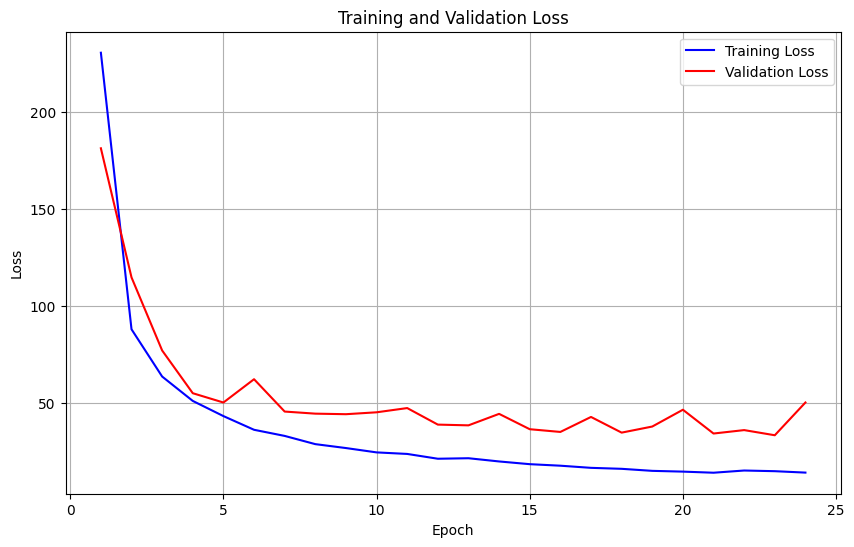

In [ ]:
import matplotlib.pyplot as plt

epochs = list(range(1, 25))
train_loss = [
    230.3899026858579, 87.90939525434166, 63.55927043355954, 50.9931274219683,
    43.18443214513694, 36.12652318189099, 32.96918888456503, 28.73120542392609,
    26.715184278548904, 24.47770042176459, 23.683984027546682, 21.20979366788439,
    21.470603432624962, 19.810259369528218, 18.40842961353861, 17.623453067366484,
    16.51842679795186, 16.016441867609693, 14.968255115922089, 14.573177337646484,
    14.00512559246865, 15.139811009168625, 14.79718075990677, 14.064417380094529
]
val_loss = [
    181.15303230285645, 114.64087181091308, 76.98570957183838, 54.968890857696536,
    50.175275039672854, 62.178778648376465, 45.514417791366576, 44.439664649963376,
    44.155246591567995, 45.13270831108093, 47.31354990005493, 38.79328966140747,
    38.411310482025144, 44.32828512191772, 36.42188596725464, 35.0176604270935,
    42.73808040618896, 34.663173627853396, 37.80206971168518, 46.45549983978272,
    34.19767136573792, 35.96300897598267, 33.31015124320984, 50.18931665420532
]

plt.figure(figsize=(10, 6))
plt.plot(epochs, train_loss, label='Training Loss', color='blue')
plt.plot(epochs, val_loss, label='Validation Loss', color='red')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
train_loader.dataset.close()
val_loader.dataset.close()

# VGG
- Epoch : 1, Loss : 183.76921428333628, Val_loss : 138.7342578125
- Epoch : 2, Loss : 128.2447030203683, Val_loss : 143.2067679595947
- Epoch : 3, Loss : 122.56000444965977, Val_loss : 96.83059211730956
- Epoch : 4, Loss : 87.70850903081437, Val_loss : 78.38082936604818
- Epoch : 5, Loss : 68.04693739406598, Val_loss : 72.64038126627604
- Epoch : 6, Loss : 57.276853927027304, Val_loss : 68.96054336547851
- Epoch : 7, Loss : 51.59112667961242, Val_loss : 57.317286516825355
- Epoch : 8, Loss : 47.01944582150006, Val_loss : 55.66085670471191
- Epoch : 9, Loss : 42.54086226624803, Val_loss : 53.47876875559489
- Epoch : 10, Loss : 39.80607411198723, Val_loss : 54.47281494140625
- Epoch : 11, Loss : 36.430880546569824, Val_loss : 54.80409914652507
- Epoch : 12, Loss : 33.627891385631195, Val_loss : 48.48928497411028
- Epoch : 13, Loss : 31.059670966142303, Val_loss : 51.898619048203095
- Epoch : 14, Loss : 28.95467392198599, Val_loss : 48.438780072369156
- Epoch : 15, Loss : 26.666760903255195, Val_loss : 49.81154549272755
- Epoch : 16, Loss : 24.51864461989919, Val_loss : 43.89916703067249